In [1]:
path = r'C:\Madhan\Analytics\Machine_Learning_project_work\AI_ML\bluepencil\model_improvement'

In [74]:
import pandas as pd
import nltk
import numpy as np
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt   
import matplotlib.style
plt.style.use('classic')
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
#importing seaborn for statistical plots
import seaborn as sns
import sklearn.metrics as metrics
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy


In [156]:
legal_data = pd.read_excel(path+'\legal_data_1.0.xlsx')

In [157]:
legal_data.head()

,Index,Filename,FileContent,Label
0,0,1003143 D4183 GISS 2 pager for Life Sciences_V...,Creating trust in \r\nthe digital world\r\nEYâ...,0
1,1,1003143 D4183 GISS 2 pager for Life Sciences_V...,"It \r\ncaptures the responses of 1,755 partici...",0
2,2,1003143 D4183 GISS 2 pager for Life Sciences_V...,The following findings from the 36 participant...,0
3,3,1003143 D4183 GISS 2 pager for Life Sciences_V...,But they also indicate the need for considerab...,0
4,4,1003143 D4183 GISS 2 pager for Life Sciences_V...,Operating in a digital world invites \r\nnew ...,0


In [158]:
legal_data.Label.value_counts()

0    30046
1      755
Name: Label, dtype: int64

In [159]:
X = legal_data.FileContent

In [160]:
print(X.iloc[0])

Creating trust in 
the digital world
EYâ€™s Global Information Security 
Survey 2015

Life sciences sector results

EYâ€™s Global Information Security Survey investigates the most important cybersecurity issues facing businesses today.


In [161]:
y = legal_data.Label

In [162]:
default_stopwords = set(nltk.corpus.stopwords.words('english'))

In [278]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    #print(tag)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    output = tag_dict.get(tag[0]) 
    if output:
        return output
    else:
        return 'v'

In [285]:
def review_to_words( SD ):
    lm = WordNetLemmatizer()
    letters_only = re.sub("[^a-zA-Z]", " ", SD)
    #print(letters_only)
    sentences = nltk.word_tokenize(str(letters_only))
    #print(sentences)
    sentences = [word.lower() for word in sentences]
    no_stops = [word for word in sentences if not word in default_stopwords]
    #print(no_stops)
    lem_word = [lm.lemmatize(word,get_wordnet_pos(word)) for word in no_stops]
    #print(lem_word)
    #tags = st.tag(lem_word)
    #tagged_words = [word for word,tag in tags if tag!='PERSON' and tag!='LOCATION']
    tokens = [word.lower() for word in lem_word if len(word) > 2]
    #print(tokens)
    return( " ".join(tokens))

In [286]:
X.iloc[1]

'It \r\ncaptures the responses of 1,755 participants around the globe and across industries, and we base our findings and conclusions \r\non those insights and on our extensive global experience working with clients to help improve their cybersecurity.'

In [287]:
review_to_words(X.iloc[1])

'capture response participant around globe across industry base finding conclusion insight extensive global experience work client help improve cybersecurity'

In [288]:
print("Number of Rows Parsed......................\n")
corpus = []
num_SD = len(X)
%time
for i in range( 0, num_SD ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%5000 == 0 ):
        print("Cleaned Short Descriptions %d of %d" % ( i+1, num_SD ))
    corpus.append( review_to_words(str(X.iloc[i])))

Number of Rows Parsed......................

Wall time: 0 ns
Cleaned Short Descriptions 5000 of 30801
Cleaned Short Descriptions 10000 of 30801
Cleaned Short Descriptions 15000 of 30801
Cleaned Short Descriptions 20000 of 30801
Cleaned Short Descriptions 25000 of 30801
Cleaned Short Descriptions 30000 of 30801


In [289]:
X = pd.DataFrame(corpus)

In [290]:
X_train_txt, X_test_txt, y_train, y_test, = train_test_split(X[0], y,test_size=0.2, random_state=1)

In [291]:
print(X_train_txt.shape)
print(X_test_txt.shape)
print(y_train.shape)
print(y_test.shape)

(24640,)
(6161,)
(24640,)
(6161,)


In [336]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,4),min_df=20,max_features=5000,lowercase=True)
X_dtm_train = tfidf_vec.fit_transform((X_train_txt))
X_dtm_train.shape

(24640, 3248)

In [337]:
X_dtm_test = tfidf_vec.transform(X_test_txt)
X_dtm_test.shape

(6161, 3248)

In [338]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [339]:
svcclassifier = SVC(random_state=0,kernel='linear')
svcclassifier.fit(X_dtm_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [340]:
svcclassifier.score(X_dtm_train,y_train)

0.9758116883116883

In [341]:
y_pred_svm = svcclassifier.predict(X_dtm_test)

In [342]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X_dtm_train,y_train)
y_pred_class_logreg = logreg.predict(X_dtm_test)

In [343]:
X_train_tokens = tfidf_vec.get_feature_names()

In [344]:
log_coef = logreg.coef_

In [345]:
np.argsort(log_coef)[-20:]

array([[1269, 1602, 1659, ..., 2251, 1015, 1606]], dtype=int64)

In [346]:
top_positive_coefficients = np.argsort(log_coef)[-20:]
top_negative_coefficients = np.argsort(log_coef)[:20]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])


In [347]:
top_positive_coefficients.reshape(-1,1)

array([[1269],
       [1602],
       [1659],
       ...,
       [2251],
       [1015],
       [1606]], dtype=int64)

In [348]:
nb = MultinomialNB()
nb.fit(X_dtm_train,y_train)
y_pred_class_nb = nb.predict(X_dtm_test)

In [349]:
import matplotlib.pyplot as plt   
import matplotlib.style
plt.style.use('classic')

#importing seaborn for statistical plots
import seaborn as sns

In [310]:
error = []
# Calculating error for K values for 5, 13 and 21
for i in range(1,49):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_dtm_train, y_train)
    pred_i = knn.predict(X_dtm_test)
    error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Mean Error')

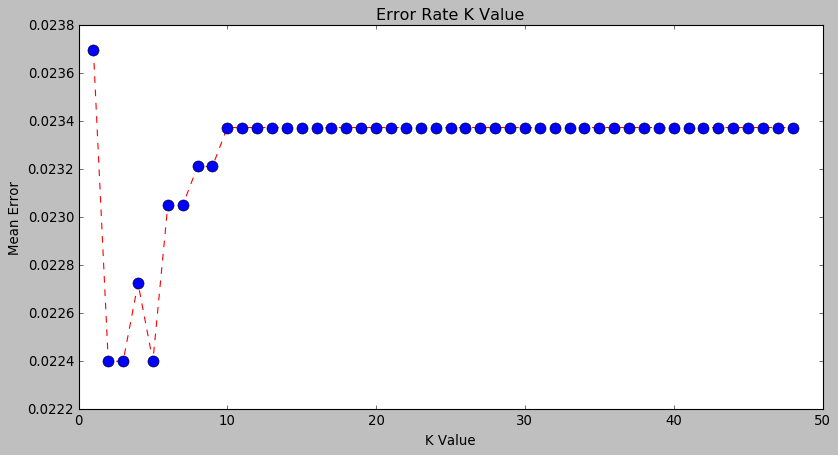

In [311]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1,49), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error') 

In [350]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_dtm_train,y_train)
y_pred_class_knn = knn.predict(X_dtm_test)

In [351]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy',random_state=0,max_depth=100,class_weight={0:.3,1:.7}, min_samples_leaf=15)
classifier.fit(X_dtm_train,y_train)
y_pred_tree = classifier.predict(X_dtm_test)

In [352]:
from sklearn.ensemble import RandomForestClassifier
rand_classifer = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0,class_weight={0:.3,1:.7})
rand_classifer.fit(X_dtm_train,y_train)
y_pred_randforest = rand_classifer.predict(X_dtm_test)

In [353]:
print("SVM ACCURACY:",metrics.accuracy_score(y_test,y_pred_svm))
print('SVM CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_svm))
print("===> **SVM F1 SCORE",metrics.f1_score(y_test, y_pred_svm,average=None))
print("===> **SVM Recall SCORE",metrics.recall_score(y_test, y_pred_svm,average=None))
print("===> **SVM Precision SCORE",metrics.precision_score(y_test, y_pred_svm,average=None))
print("===> **SVM ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_svm,average=None))
print("##################################################################################################")
print("LogisticReg ACCURACY:",metrics.accuracy_score(y_test,y_pred_class_logreg,))
print('LogisticReg CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_class_logreg))
print("===> **LogisticReg F1 SCORE",metrics.f1_score(y_test, y_pred_class_logreg,average=None))
print("===> **LogisticReg Recall SCORE",metrics.recall_score(y_test, y_pred_class_logreg,average=None))
print("===> **LogisticReg Precision SCORE",metrics.precision_score(y_test, y_pred_class_logreg,average=None))
print("===> **LogisticReg ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_class_logreg,average=None))
print("##################################################################################################")
print("NaiveBayes ACCURACY:",metrics.accuracy_score(y_test,y_pred_class_nb))
print('NaiveBayes CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_class_nb))
print("===> **NaiveBayes F1 SCORE",metrics.f1_score(y_test, y_pred_class_nb,average=None))
print("===> **NaiveBayes Recall SCORE",metrics.recall_score(y_test, y_pred_class_nb,average=None))
print("===> **NaiveBayes Precision SCORE",metrics.precision_score(y_test, y_pred_class_nb,average=None))
print("===> **NaiveBayes ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_class_nb,average=None))
print("##################################################################################################")
print("KNN ACCURACY:",metrics.accuracy_score(y_test,y_pred_class_knn))
print('KNN CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_class_knn))
print("===> **KNN F1 SCORE",metrics.f1_score(y_test, y_pred_class_knn,average=None))
print("===> **KNN Recall SCORE",metrics.recall_score(y_test, y_pred_class_knn,average=None))
print("===> **KNN Precision SCORE",metrics.precision_score(y_test, y_pred_class_knn,average=None))
print("===> **KNN ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_class_knn,average=None))
print("##################################################################################################")
print("Dtree ACCURACY:",metrics.accuracy_score(y_test,y_pred_tree))
print('Dtree CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_tree))
print("===> **Dtree F1 SCORE",metrics.f1_score(y_test, y_pred_tree,average=None))
print("===> **Dtree Recall SCORE",metrics.recall_score(y_test, y_pred_tree,average=None))
print("===> **Dtree Precision SCORE",metrics.precision_score(y_test, y_pred_tree,average=None))
print("===> **Dtree ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_tree,average=None))
print("##################################################################################################")
print("RandForest ACCURACY:",metrics.accuracy_score(y_test,y_pred_randforest))
print('RandForest CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_randforest))
print("===> **RandForest F1 SCORE",metrics.f1_score(y_test, y_pred_randforest,average=None))
print("===> **RandForest Recall SCORE",metrics.recall_score(y_test, y_pred_randforest,average=None))
print("===> **RandForest Precision SCORE",metrics.precision_score(y_test, y_pred_randforest,average=None))
print("===> **RandForest ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_randforest,average=None))

SVM ACCURACY: 0.9766271709138127
SVM CLASSIFIER CONFUSTION MATRIX: col_0     0
Label      
0      6017
1       144


C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


===> **SVM F1 SCORE [0.9881754 0.       ]
===> **SVM Recall SCORE [1. 0.]


C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


===> **SVM Precision SCORE [0.97662717 0.        ]
===> **SVM ROC_AUC SCORE 0.5
##################################################################################################
LogisticReg ACCURACY: 0.9527674078883298
LogisticReg CLASSIFIER CONFUSTION MATRIX: col_0     0    1
Label           
0      5831  186
1       105   39
===> **LogisticReg F1 SCORE [0.97565465 0.21138211]
===> **LogisticReg Recall SCORE [0.96908759 0.27083333]
===> **LogisticReg Precision SCORE [0.98231132 0.17333333]
===> **LogisticReg ROC_AUC SCORE 0.619960459254335
##################################################################################################
NaiveBayes ACCURACY: 0.9767894822269112
NaiveBayes CLASSIFIER CONFUSTION MATRIX: col_0     0  1
Label         
0      6014  3
1       140  4
===> **NaiveBayes F1 SCORE [0.98825076 0.05298013]
===> **NaiveBayes Recall SCORE [0.99950141 0.02777778]
===> **NaiveBayes Precision SCORE [0.97725057 0.57142857]
===> **NaiveBayes ROC_AUC SCORE 0.51363959522094

In [316]:
y.value_counts()

0    30046
1      755
Name: Label, dtype: int64

In [317]:
30046*.05

1502.3000000000002

In [318]:
df_corpus = pd.DataFrame(corpus,columns=['text'])

In [319]:
df_cleaned = pd.concat([df_corpus,legal_data['Label']],axis=1)

In [354]:
def build_model_samples(s,df):
    SVM_f1 = []
    SVM_recall = []
    logreg_f1 = []
    rf_f1 = []
    logreg_recall = []
    rf_recall = []
    for sam in range(s):
        Non_Leg = df_cleaned[df_cleaned['Label']== 0].sample(800,random_state=sam,replace=False)
        Leg = df_cleaned[df_cleaned['Label']==1]
        df_sampled = pd.concat([Non_Leg,Leg],axis=0)
        X = df_sampled.text
        y = df_sampled.Label
        X_train_txt, X_test_txt, y_train, y_test, = train_test_split(X, y,test_size=0.2, random_state=1)
        X_dtm_train = tfidf_vec.fit_transform((X_train_txt))
        X_dtm_test = tfidf_vec.transform(X_test_txt)
        #print(X_dtm_train.shape)
        #print(X_dtm_test.shape)
        svcclassifier = SVC(random_state=0,kernel='linear',C=3)
        svcclassifier.fit(X_dtm_train,y_train)
        y_pred_svm = svcclassifier.predict(X_dtm_test)
        SVM_f1.append(metrics.f1_score(y_test, y_pred_svm,average=None))
        SVM_recall.append(metrics.recall_score(y_test, y_pred_svm,average=None))
        print("SVM Fitted for sample",sam)
        logreg.fit(X_dtm_train,y_train)
        y_pred_class_logreg = logreg.predict(X_dtm_test)
        logreg_f1.append(metrics.f1_score(y_test, y_pred_class_logreg,average=None))
        logreg_recall.append(metrics.recall_score(y_test, y_pred_class_logreg,average=None))
        print("Logreg Fitted for sample",sam)
        rand_classifer = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0)
        rand_classifer.fit(X_dtm_train,y_train)
        y_pred_randforest = rand_classifer.predict(X_dtm_test)
        print(metrics.confusion_matrix(y_test,y_pred_randforest))
        rf_f1.append(metrics.f1_score(y_test, y_pred_randforest,average=None))
        rf_recall.append(metrics.recall_score(y_test, y_pred_randforest,average=None))
        print("RF Fitted for sample",sam)
    return SVM_recall, SVM_f1, logreg_recall,logreg_f1,rf_recall,rf_f1

In [355]:
output = build_model_samples(10,df_cleaned)

SVM Fitted for sample 0
Logreg Fitted for sample 0
[[122  45]
 [ 34 110]]
RF Fitted for sample 0
SVM Fitted for sample 1
Logreg Fitted for sample 1
[[127  40]
 [ 31 113]]
RF Fitted for sample 1
SVM Fitted for sample 2
Logreg Fitted for sample 2
[[127  40]
 [ 33 111]]
RF Fitted for sample 2
SVM Fitted for sample 3
Logreg Fitted for sample 3
[[129  38]
 [ 27 117]]
RF Fitted for sample 3
SVM Fitted for sample 4
Logreg Fitted for sample 4
[[135  32]
 [ 27 117]]
RF Fitted for sample 4
SVM Fitted for sample 5
Logreg Fitted for sample 5
[[138  29]
 [ 30 114]]
RF Fitted for sample 5
SVM Fitted for sample 6
Logreg Fitted for sample 6
[[134  33]
 [ 33 111]]
RF Fitted for sample 6
SVM Fitted for sample 7
Logreg Fitted for sample 7
[[133  34]
 [ 22 122]]
RF Fitted for sample 7
SVM Fitted for sample 8
Logreg Fitted for sample 8
[[121  46]
 [ 29 115]]
RF Fitted for sample 8
SVM Fitted for sample 9
Logreg Fitted for sample 9
[[131  36]
 [ 25 119]]
RF Fitted for sample 9


In [356]:
output

([array([0.78443114, 0.74305556]),
  array([0.73053892, 0.77777778]),
  array([0.74251497, 0.77777778]),
  array([0.77844311, 0.76388889]),
  array([0.79640719, 0.77777778]),
  array([0.76646707, 0.77777778]),
  array([0.74251497, 0.72916667]),
  array([0.77844311, 0.79861111]),
  array([0.76047904, 0.76388889]),
  array([0.78443114, 0.78472222])],
 [array([0.78208955, 0.7456446 ]),
  array([0.76012461, 0.74418605]),
  array([0.76780186, 0.74916388]),
  array([0.78549849, 0.75601375]),
  array([0.80120482, 0.77241379]),
  array([0.78287462, 0.75932203]),
  array([0.75151515, 0.71917808]),
  array([0.79754601, 0.77702703]),
  array([0.77439024, 0.74829932]),
  array([0.79635258, 0.77133106])],
 [array([0.76047904, 0.72916667]),
  array([0.73652695, 0.79166667]),
  array([0.7245509 , 0.75694444]),
  array([0.77245509, 0.77777778]),
  array([0.79041916, 0.77083333]),
  array([0.80838323, 0.75694444]),
  array([0.71856287, 0.75694444]),
  array([0.79041916, 0.75694444]),
  array([0.7125748

In [323]:
SVM_recall = pd.DataFrame(output[0],columns=['Non_Legal','Legal'])
SVM_F1 = pd.DataFrame(output[1],columns=['Non_Legal','Legal'])
logreg_recall = pd.DataFrame(output[2],columns=['Non_Legal','Legal'])
logreg_F1 = pd.DataFrame(output[3],columns=['Non_Legal','Legal'])
RF_recall = pd.DataFrame(output[4],columns=['Non_Legal','Legal'])
RF_F1 = pd.DataFrame(output[5],columns=['Non_Legal','Legal'])

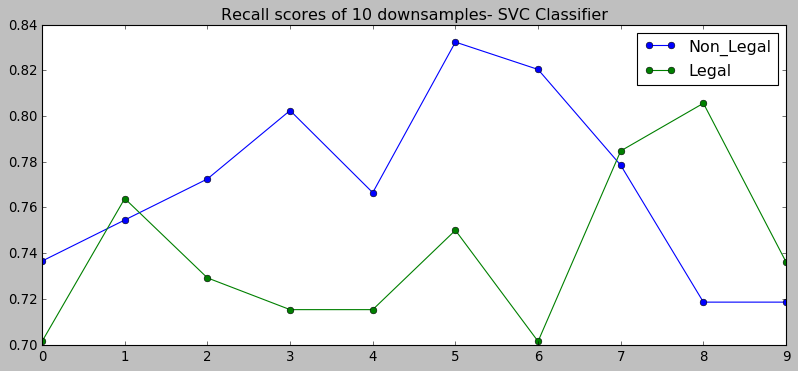

In [324]:

SVM_recall.plot(figsize=(12,5),title='Recall scores of 10 downsamples- SVC Classifier',marker='o')

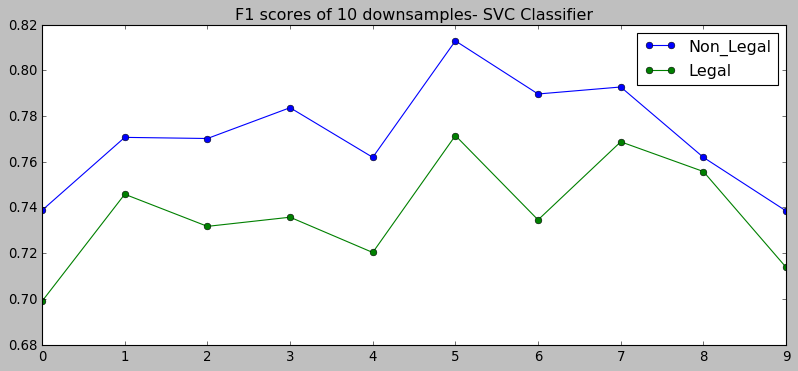

In [325]:
SVM_F1.plot(figsize=(12,5),title='F1 scores of 10 downsamples- SVC Classifier',marker='o')

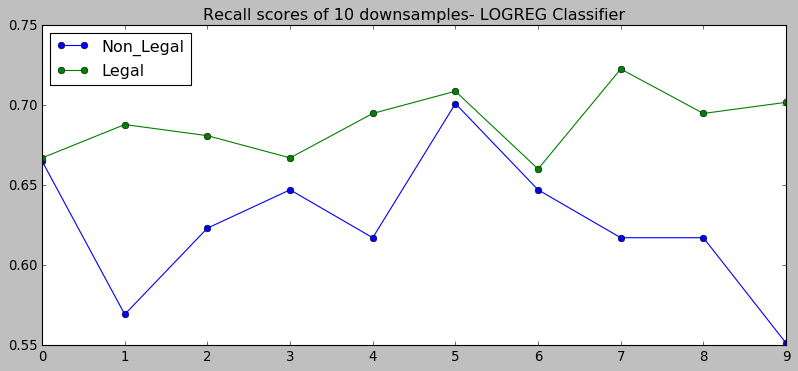

In [326]:

logreg_recall.plot(figsize=(12,5),title='Recall scores of 10 downsamples- LOGREG Classifier',marker='o')

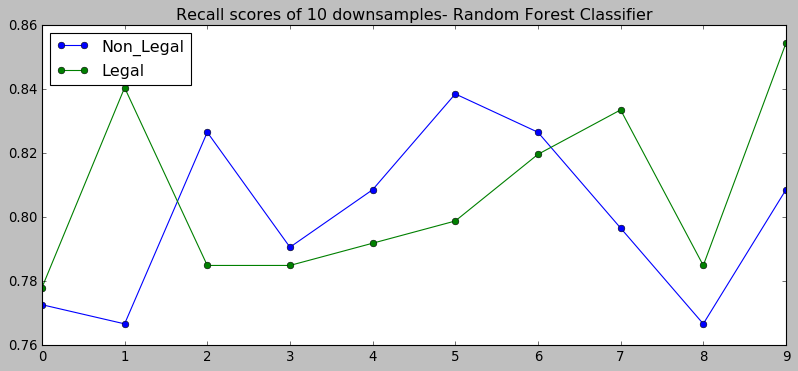

In [327]:
RF_recall.plot(figsize=(12,5),title='Recall scores of 10 downsamples- Random Forest Classifier',marker='o')

## PipeLine

In [328]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.grid_search import GridSearchCV

C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [329]:
#rand_classifer = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0,class_weight={0:.3,1:.7})
rand_classifer = RandomForestClassifier()

In [330]:
rand_classifer

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [333]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=100,random_state=0)),])
parameters = {
    'tfidf__min_df': (10,20,30,40,50),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),(1,4),(1,5),(1,6),(1,7)],
    'tfidf__max_features': (5000,6000,7000,8000),
    #'clf__n_estimators':(20,50,75,100),
    #'clf__criterion': ('gini','entropy'),
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train_txt, y_train)
print(grid_search_tune.score(X_train_txt,y_train))

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

Fitting 2 folds for each of 140 candidates, totalling 280 fits


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 14.2min
[Parallel(n_jobs=2)]: Done 280 out of 280 | elapsed: 30.6min finished


0.9991071428571429
Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=20,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]


In [334]:
280/16

17.5

In [358]:
Non_Leg = df_cleaned[df_cleaned['Label']== 0].sample(800,random_state=1,replace=False)
Leg = df_cleaned[df_cleaned['Label']==1]
df_sampled = pd.concat([Non_Leg,Leg],axis=0)
X_sam = df_sampled.text
y_sam = df_sampled.Label

In [359]:
X_train_txt, X_test_txt, y_train, y_test, = train_test_split(X_sam, y_sam,test_size=0.2, random_state=1)
X_dtm_train = tfidf_vec.fit_transform((X_train_txt))
X_dtm_test = tfidf_vec.transform(X_test_txt)

In [360]:
from sklearn.ensemble import RandomForestClassifier
rand_classifer = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0,class_weight={0:.3,1:.7})
rand_classifer.fit(X_dtm_train,y_train)
y_pred_randforest = rand_classifer.predict(X_dtm_test)

In [361]:
print("RandForest ACCURACY:",metrics.accuracy_score(y_test,y_pred_randforest))
print('RandForest CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_randforest))
print("===> **RandForest F1 SCORE",metrics.f1_score(y_test, y_pred_randforest,average=None))
print("===> **RandForest Recall SCORE",metrics.recall_score(y_test, y_pred_randforest,average=None))
print("===> **RandForest Precision SCORE",metrics.precision_score(y_test, y_pred_randforest,average=None))
print("===> **RandForest ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_randforest,average=None))

RandForest ACCURACY: 0.7588424437299035
RandForest CLASSIFIER CONFUSTION MATRIX: col_0    0    1
Label          
0      121   46
1       29  115
===> **RandForest F1 SCORE [0.76340694 0.75409836]
===> **RandForest Recall SCORE [0.7245509  0.79861111]
===> **RandForest Precision SCORE [0.80666667 0.71428571]
===> **RandForest ROC_AUC SCORE 0.7615810046573521


In [362]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, max_depth=10)
gbcl = gbcl.fit(X_dtm_train, y_train)

In [363]:
y_pred_gbcl = gbcl.predict(X_dtm_test)

In [364]:
print("GBC: ACCURACY:",metrics.accuracy_score(y_test,y_pred_gbcl))
print('GBC CLASSIFIER CONFUSTION MATRIX:%\n',pd.crosstab(y_test,y_pred_gbcl))
print("===> **GBC F1 SCORE",metrics.f1_score(y_test, y_pred_gbcl,average=None))
print("===> **GBC Recall SCORE",metrics.recall_score(y_test, y_pred_gbcl,average=None))
print("===> **GBC Precision SCORE",metrics.precision_score(y_test, y_pred_gbcl,average=None))
print("===> **GBC ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_gbcl,average=None))

GBC: ACCURACY: 0.7170418006430869
GBC CLASSIFIER CONFUSTION MATRIX:%
 col_0    0    1
Label          
0      120   47
1       41  103
===> **GBC F1 SCORE [0.73170732 0.70068027]
===> **GBC Recall SCORE [0.71856287 0.71527778]
===> **GBC Precision SCORE [0.74534161 0.68666667]
===> **GBC ROC_AUC SCORE 0.7169203260146374


## LSTM Network

In [365]:
from keras.datasets import imdb
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras import callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence


C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [366]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train_txt)
sequences_train = tok.texts_to_sequences(X_train_txt)
sequences_test = tok.texts_to_sequences(X_test_txt)
#load dataset as a list of ints
#(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
#make all sequences of the same length
x_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test =  sequence.pad_sequences(sequences_test, maxlen=maxlen)

In [367]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, 128))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
#lstm_model.add(Flatten())
#lstm_model.add(Dense(250, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                         patience=2, verbose=0, mode='auto')

# Compile and train.
lstm_model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [368]:
lstm_model.fit(x_train, y_train, batch_size=64, epochs=20,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

loss, acc = lstm_model.evaluate(x_test, y_test, batch_size=64)

print('Test loss (LOWER is better)      :', loss)
print('Test accuracy (HIGHER is better) :', acc)

Train on 1244 samples, validate on 311 samples
Epoch 1/20
1244/1244 [==============================] - ETA: 1:11 - loss: 0.6923 - acc: 0.562 - ETA: 47s - loss: 0.6919 - acc: 0.562 - ETA: 39s - loss: 0.6919 - acc: 0.56 - ETA: 34s - loss: 0.6917 - acc: 0.55 - ETA: 31s - loss: 0.6903 - acc: 0.57 - ETA: 27s - loss: 0.6894 - acc: 0.59 - ETA: 25s - loss: 0.6876 - acc: 0.59 - ETA: 22s - loss: 0.6869 - acc: 0.58 - ETA: 20s - loss: 0.6842 - acc: 0.59 - ETA: 17s - loss: 0.6824 - acc: 0.58 - ETA: 15s - loss: 0.6827 - acc: 0.57 - ETA: 13s - loss: 0.6815 - acc: 0.57 - ETA: 11s - loss: 0.6764 - acc: 0.58 - ETA: 9s - loss: 0.6749 - acc: 0.5848 - ETA: 7s - loss: 0.6758 - acc: 0.582 - ETA: 6s - loss: 0.6740 - acc: 0.585 - ETA: 4s - loss: 0.6710 - acc: 0.594 - ETA: 2s - loss: 0.6702 - acc: 0.600 - ETA: 0s - loss: 0.6688 - acc: 0.605 - 36s 29ms/step - loss: 0.6678 - acc: 0.6077 - val_loss: 0.6291 - val_acc: 0.6785
Epoch 2/20
1244/1244 [==============================] - ETA: 29s - loss: 0.6013 - acc: 0.68

In [369]:
lstm_pred = lstm_model.predict_classes(x_test)

In [370]:
print("LSTM ACCURACY:",metrics.accuracy_score(y_test,lstm_pred))
print('LSTM CLASSIFIER CONFUSTION MATRIX:',metrics.accuracy_score(y_test,lstm_pred))
print("===> **LSTM F1 SCORE",metrics.f1_score(y_test, lstm_pred,average=None))
print("===> **LSTM Recall SCORE",metrics.recall_score(y_test, lstm_pred,average=None))
print("===> **LSTM Precision SCORE",metrics.precision_score(y_test, lstm_pred,average=None))
print("===> **LSTM ROC_AUC SCORE",metrics.roc_auc_score(y_test, lstm_pred,average=None))
print("#######################################################################################")

LSTM ACCURACY: 0.7395498392282959
LSTM CLASSIFIER CONFUSTION MATRIX: 0.7395498392282959
===> **LSTM F1 SCORE [0.75528701 0.72164948]
===> **LSTM Recall SCORE [0.74850299 0.72916667]
===> **LSTM Precision SCORE [0.76219512 0.71428571]
===> **LSTM ROC_AUC SCORE 0.7388348303393213
#######################################################################################


In [374]:
test = pd.read_csv(r'C:\Madhan\Analytics\Machine_Learning_project_work\AI_ML\bluepencil\model_improvement\test_set_1.csv')

In [375]:
test.head()

,Unnamed: 0,filename,fileContent,Label
0,0,-01-0290_Folder Tax_Vat_2017_Internet.pdf,13th Directive \r\r\nEU VAT refund \r\r\nreque...,Legal
1,1,-01-0290_Folder Tax_Vat_2017_Internet.pdf,Country\r\r\nAustria \r\r\nBelgium\r\r\nBulgar...,Non-Legal
2,2,-01-0290_Folder Tax_Vat_2017_Internet.pdf,2\r\r\n\r\r\n| 13th Directive EU VAT refund ...,Legal
3,3,-01-0290_Folder Tax_Vat_2017_Internet.pdf,"A company established in Hong Kong, Taiwan, Ma...",Non-Legal
4,4,-01-0290_Folder Tax_Vat_2017_Internet.pdf,"In particular, \r\r\nthe Asian company must:\r...",Non-Legal


In [377]:
X = test.fileContent

In [378]:
print("Number of Rows Parsed......................\n")
corpus = []
num_SD = len(X)
%time
for i in range( 0, num_SD ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%5000 == 0 ):
        print("Cleaned Short Descriptions %d of %d" % ( i+1, num_SD ))
    corpus.append( review_to_words(str(X.iloc[i])))

Number of Rows Parsed......................

Wall time: 0 ns
Cleaned Short Descriptions 5000 of 39055
Cleaned Short Descriptions 10000 of 39055
Cleaned Short Descriptions 15000 of 39055
Cleaned Short Descriptions 20000 of 39055
Cleaned Short Descriptions 25000 of 39055
Cleaned Short Descriptions 30000 of 39055
Cleaned Short Descriptions 35000 of 39055


In [379]:
X_dtm_test = tfidf_vec.transform(corpus)

In [380]:
X_dtm_test.shape

(39055, 255)

In [381]:
y_pred_randforest = rand_classifer.predict(X_dtm_test)

In [384]:
y_pred_randforest = pd.DataFrame(y_pred_randforest)

In [385]:
test_1 = pd.concat([test,y_pred_randforest],axis=1)

In [386]:
test_1.to_csv('test1.csv')